In [195]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = '/Volumes/Expansion/Datos G. omarorum/Fish3/Objeto/Trial 1 y 2/' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_vid = sorted(glob.glob('*.h5'))
on_off1 = pd.read_csv(os.path.join(data_folder, 'on_off_trial1.csv'), header=None) #asegurarse de terner los .csv en la misma carpeta que el pkl
on_off2 = pd.read_csv(os.path.join(data_folder, 'on_off_trial2.csv'), header=None)
files_EOD = sorted(glob.glob('*.bin'))

#definimos parametros
sf = 10000

In [197]:
#cargamos el archivo de FB-DOE
with open('fish2_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

In [198]:
# generamos la lista files_start que contiene las timestamps en formato datetime del comienzo de cada uno de los archivos
files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in FB_doe['FB-DOE'].keys()]
print(files_start)# convertimos on_off1 a formato datetime
on_off1[0] = on_off1[0].apply(lambda x: datetime.fromisoformat(x[:-6]))

# ahora pasamos on_off1 a formato dataframe y nos quedamos solo con la columna de tiempo de on 
on_off = pd.DataFrame(np.zeros(shape=(len(on_off1), 2)), columns=['Trial 1', 'Trial 2'])
on_off['Trial 1'] = on_off1.drop(on_off1.columns[[1, 2]], axis=1)

# hacemos lo mismo con on_off2 y lo agregamos al dataframe on_off
on_off2[0] = on_off2[0].apply(lambda x: datetime.fromisoformat(x[:-6]))
on_off['Trial 2'] = on_off2.drop(on_off2.columns[[1, 2]], axis=1)

[datetime.datetime(2024, 1, 10, 16, 58, 2), datetime.datetime(2024, 1, 10, 17, 18, 2), datetime.datetime(2024, 1, 10, 17, 38, 2), datetime.datetime(2024, 1, 10, 17, 58, 2), datetime.datetime(2024, 1, 10, 18, 18, 3), datetime.datetime(2024, 1, 10, 18, 38, 3), datetime.datetime(2024, 1, 10, 18, 58, 3), datetime.datetime(2024, 1, 10, 19, 18, 3), datetime.datetime(2024, 1, 10, 19, 38, 3), datetime.datetime(2024, 1, 10, 19, 58, 3), datetime.datetime(2024, 1, 10, 20, 18, 3), datetime.datetime(2024, 1, 10, 20, 38, 4), datetime.datetime(2024, 1, 10, 20, 58, 4), datetime.datetime(2024, 1, 10, 21, 18, 4), datetime.datetime(2024, 1, 10, 21, 38, 4), datetime.datetime(2024, 1, 10, 21, 58, 4), datetime.datetime(2024, 1, 10, 22, 18, 4), datetime.datetime(2024, 1, 10, 22, 38, 5), datetime.datetime(2024, 1, 10, 22, 58, 5), datetime.datetime(2024, 1, 10, 23, 18, 5), datetime.datetime(2024, 1, 10, 23, 38, 5), datetime.datetime(2024, 1, 10, 23, 58, 5), datetime.datetime(2024, 1, 11, 0, 18, 5), datetime.da

In [199]:
# guardamos algunos tiempos de referencia para filtrar los archivos 
trial1_last = on_off['Trial 1'].iloc[-1]
trial2_last = on_off['Trial 2'].iloc[-1]
trial2_first = on_off['Trial 2'].iloc[0]

# generamos n_trial1 y n_trial2 que contiene los indices de los archivos que nos interesan para cada trial
n_trial1 = [i for i, start in enumerate(files_start) if (start - trial1_last).total_seconds() < 0]
n_trial2 = [i for i, start in enumerate(files_start) if (start - trial2_last).total_seconds() < 0 and (start - trial2_first).total_seconds() > 0]

# Achatamos on_off y lo ordenamos
on_off = pd.DataFrame(on_off.values.flatten(), columns=['On_off']).sort_values(by='On_off')
on_off.reset_index(inplace=True)

In [200]:
files_start = [files_start[x] for x in n_trial1 + n_trial2] #nos quedamos solo con los timestamps de los archivos de interes

FB_DOE = FB_doe['FB-DOE'] #guardamos las frequencias en una variable
Peak_time = FB_doe['Peak-time'] # guardamos los peak-times en otra variable

keys1 = [list(FB_DOE.keys())[i] for i in n_trial1] #guardamos las keys del trial 1
keys2 = [list(FB_DOE.keys())[i] for i in n_trial2] #guardamos las keys del trial 2

FB_DOE_T1 = {key: FB_DOE.get(key) for key in keys1} # guardamos las frecuencias del trial 1 
Peaks_T1 = {key: Peak_time.get(key) for key in keys1}  #guardamos los peak-times del trial 1
FB_DOE_T2 = {key: FB_DOE.get(key) for key in keys2}  #guardamos las frecuencias del trial 2
Peaks_T2 = {key: Peak_time.get(key) for key in keys2} #guardamos los peak-times del trial 2

n_files = len(FB_DOE_T1) + len(FB_DOE_T2) #guardamos el numero de files con el que estamos trabajando para usar despues

In [201]:
#organizamos cada on segun su archivo de registro
files = pd.DataFrame(np.zeros(shape=(4, n_files)), columns=list(FB_DOE_T1.keys()) + list(FB_DOE_T2.keys()))  # Usamos Int64Dtype para que pueda haber nans en columnas de int

for i, column in enumerate(files.columns[:-1], start=0):
    start = files_start[i]
    end = files_start[i+1]
    s = 0
    for j in range(len(on_off)):
        condition = (start - on_off['On_off'][j]).total_seconds() < 0 and (end - on_off['On_off'][j]).total_seconds() > 0
        if condition:
            files.loc[s, column] = j
            s += 1

files = files.dropna(how='all')
files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
files.iloc[0, 0] = 0 # el primer objeto tiene que ser un 0
files = files.dropna(how='all')

files

,2024-01-10T16_58_02.,2024-01-10T17_18_02.,2024-01-10T17_38_02.,2024-01-10T17_58_02.,2024-01-10T18_18_03.,2024-01-10T18_38_03.,2024-01-10T18_58_03.,2024-01-10T19_18_03.,2024-01-10T19_38_03.,2024-01-10T19_58_03.,...,2024-01-11T05_58_08.,2024-01-11T06_18_08.,2024-01-11T06_38_08.,2024-01-11T06_58_08.,2024-01-11T07_18_08.,2024-01-11T07_38_09.,2024-01-11T07_58_09.,2024-01-11T08_18_09.,2024-01-11T08_38_09.,2024-01-11T08_58_09.
0,0.0,5.0,10.0,15.0,20.0,24.0,29.0,34.0,39.0,44.0,...,75.0,80.0,84.0,89.0,94.0,99.0,104.0,109.0,114.0,NaN
1,1.0,6.0,11.0,16.0,21.0,25.0,30.0,35.0,40.0,45.0,...,76.0,81.0,85.0,90.0,95.0,100.0,105.0,110.0,115.0,NaN
2,2.0,7.0,12.0,17.0,22.0,26.0,31.0,36.0,41.0,46.0,...,77.0,82.0,86.0,91.0,96.0,101.0,106.0,111.0,116.0,NaN
3,3.0,8.0,13.0,18.0,23.0,27.0,32.0,37.0,42.0,47.0,...,78.0,83.0,87.0,92.0,97.0,102.0,107.0,112.0,117.0,NaN
4,4.0,9.0,14.0,19.0,NaN,28.0,33.0,38.0,43.0,48.0,...,79.0,NaN,88.0,93.0,98.0,103.0,108.0,113.0,118.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
#inicializamos las listas
EOD_peaks_on = {'Trial 1': [], 'Trial 2': []}
time_EOD_all  = {'Trial 1': [], 'Trial 2': []}
time_obj_all = {'Trial 1': [], 'Trial 2': []}
EOD_f_on = {'Trial 1': [], 'Trial 2': []}

In [203]:
for k in range(len(files.keys())-1): #loopeamos entre los archivos de interes
    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[k],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+len(EOD)/sf, num=len(EOD))
    del EOD
    
    time_obj = np.zeros((6)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)
    
    if k < len(n_trial1):
        key = 'Trial 1'
        EOD_peaks = np.array(Peaks_T1[list(Peaks_T1.keys())[k]])
        EOD_freq = np.array(FB_DOE_T1[list(FB_DOE_T1.keys())[k]])
    
    else:
        key = 'Trial 2'
        EOD_peaks = np.array(Peaks_T2[list(Peaks_T2.keys())[k-len(n_trial1)]])
        EOD_freq = np.array(FB_DOE_T2[list(FB_DOE_T2.keys())[k-len(n_trial1)]])
        
    l=0
    for i in files.iloc[:,k]:
        if not np.isnan(i):
                s = abs(midnight - on_off['On_off'][int(i)]).total_seconds() #calculamos el inicio del on
                time_obj[l] = s
                time_obj_all[key].append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all[key].append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l+=1
  
    time_peaks = time_EOD[EOD_peaks]
    for j in range(time_obj.shape[0]):
        if not time_obj[j]==0:
            range_on = [time_obj[j]-.5, time_obj[j]+10] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
            
            condition = [range_on[0] <= time and time <= range_on[1] for time in time_peaks]
            condition2 = (np.max(EOD_freq[condition[:-1]]) - np.min(EOD_freq[condition[:-1]])) > 10 if len(EOD_freq[condition[:-1]]) > 0 else False
            if condition2:
                EOD_peaks_on[key].append(EOD_peaks[condition])
                EOD_f_on[key].append(EOD_freq[condition[:-1]])
            else:
                 index = time_obj_all[key].index(time_obj[j])
                 time_obj_all[key].remove(time_obj[j])
                 del time_EOD_all[key][index]

    print('termino archivo ' + str(k))

termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11
termino archivo 12
termino archivo 13
termino archivo 14
termino archivo 15
termino archivo 16
termino archivo 17
termino archivo 18
termino archivo 19
termino archivo 20
termino archivo 21
termino archivo 22
termino archivo 23


In [204]:
for key in ['Trial 1', 'Trial 2']:
    EOD_peaks_on[key] = [sublist for sublist in EOD_peaks_on[key] if len(sublist) > 0]
    EOD_f_on[key] = [sublist for sublist in EOD_f_on[key] if len(sublist) > 0]

In [205]:
ventanas = [(i-.2, i) for i in np.linspace(0, 10, 200)] #generamos las ventanas de tiempo (100ms) a la cual redondearemos para calcular la mediana.

median_ventanas= {'Trial 1': [], 'Trial 2': []} #inicializamos el diccionario median que va a tener un subdiccionario para cada trial (cada subdiccionario sera el diccionario medians que inicializamos antes)
for key in EOD_peaks_on.keys():
    time = time_EOD_all[key]
    obj = time_obj_all[key]
    EOD_BR = EOD_f_on[key]
    peaks = EOD_peaks_on[key]
    l = 0

    indexes = on_off['On_off']
    for freq, peak, t, o in zip(EOD_BR, peaks, time,  obj):
        x = t[peak] - o #tiempo relativo al objeto, el cual vamos a redondear
        m= []
        for rango in ventanas:
            m.append(np.mean(freq[[rango[0] <= i and rango[1] >= i for i in x]]))

        median_ventanas[key].append(m)

In [206]:
medians_all_trials = {}

T1 = np.vstack(median_ventanas['Trial 1'])
T2 = np.vstack(median_ventanas['Trial 2'])
print(type(T1), type(T2))
medians_all_trials['Trial 1'] = np.median(T1, axis=0)
medians_all_trials['Trial 2'] = np.median(T2, axis=0)
medians_all_trials['all'] = np.median(np.vstack([T1, T2]), axis=0)
print(medians_all_trials['all'].shape, medians_all_trials['Trial 1'].shape, medians_all_trials['Trial 2'].shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(200,) (200,) (200,)


In [207]:
import matplotlib.cm as cm
colormap = cm.get_cmap('Blues')
colors = [colormap(i+100) for i in range(len(time_obj_all['Trial 1'])+len(time_obj_all['Trial 2']))]

/var/folders/dk/0fvz37fn27l9149spycxsyf80000gp/T/ipykernel_8063/2913976248.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


In [215]:
k

0.01

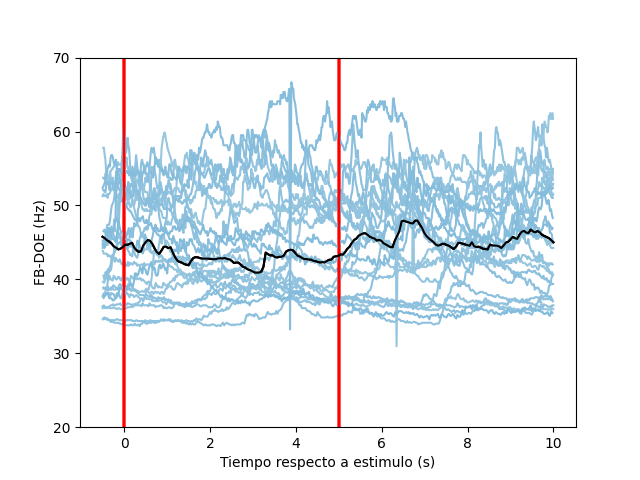

In [226]:
%matplotlib widget 
#plot all trials
fig, ax = plt.subplots()
for key in EOD_peaks_on.keys():
    

    time = time_EOD_all[key]
    obj = time_obj_all[key]
    EOD_BR = EOD_f_on[key]
    peaks = EOD_peaks_on[key]
    
    for freq, peak, t, o, color in zip(EOD_BR, peaks, time,  obj, colors):
        indexes = freq > 20
        freq = freq[indexes]
        peak = peak[indexes]
        ax.plot(t[peak]-o, freq, color=color)
        ax.axvline(x=0, color='red', linestyle='-', label='Vertical Line')
        ax.axvline(x=5, color='red', linestyle='-', label='Vertical Line')
 

    ax.plot(np.linspace(-.5, 10, len(medians_all_trials['all'])), medians_all_trials['all'], color='k')
    ax.set_ylim([20,70])
    ax.set_ylabel('FB-DOE (Hz)')
    ax.set_xlabel('Tiempo respecto a estimulo (s)')

plt.show()

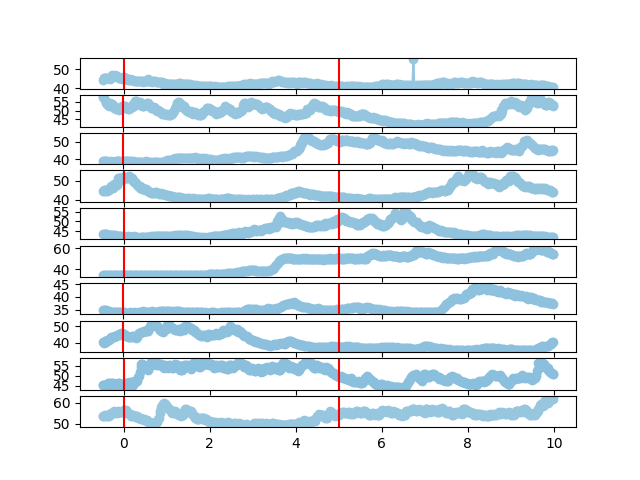

In [227]:
from scipy.signal import hilbert
def find_envelope(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

fig, ax = plt.subplots(nrows=10, ncols=1)
s=0
for key in EOD_peaks_on.keys():
    time = time_EOD_all[key]
    obj = time_obj_all[key]
    EOD_BR = EOD_f_on[key]
    peaks = EOD_peaks_on[key]
    for freq, peak, t, o, color in zip(EOD_BR, peaks, time,  obj, colors):
            if s<10:
                indexes = freq > 20
                freq = freq[indexes]
                peak = peak[indexes]
                envelope = find_envelope(freq)
                ax[s].plot(t[peak]-o, freq, color=color)
                ax[s].scatter(t[peak]-o, freq, color=color)

                #ax[s].plot(t[peak]-o, envelope, color='k')
                ax[s].axvline(x=0, color='red', linestyle='-', label='Vertical Line')
                ax[s].axvline(x=5, color='red', linestyle='-', label='Vertical Line')
                s += 1
plt.show()